# Background

- **Author**: `<郭伊軒>`
- **Created At**: `<2025-10-30>`
- **Research Motivation and Context (why are we interested in the findings?)：**  
本研究透過時間序列視覺化的方式，探討遊戲在不同事件（如季節促銷、DLC 發行、續作推出）下或其玩家數、追蹤者數與好評率變化對折扣時間點的影響。藉由同時觀察季節促銷與非季節折扣期間的背景變化，研究可進一步辨識不同類型促銷活動對商家折扣行為的差異性。
- **Main Findings and Takeaways：**    
    - 在非季節性折扣時點前後，其玩家數、追蹤者數與好評率變化有折扣前下降折扣後上升的趨勢。

    - 是否發行DLC相較於是否發行續作有較高的打折機率。

- **Future Direciton：**  
    - 比較競爭對手活動 / 市場整體狀況：同類型遊戲中打折比例、同時期平均價格下降幅度。

    - 比較不同遊戲類型或發行商之間的差異：分析不同遊戲類型或發行商在折扣策略上的差異。

    - 結合機器學習模型進行折扣預測：例如利用 Random Forest 或 XGBoost 模型預測折扣時點，以驗證變數重要性並提升實務應用價值。


In [ ]:
# Load packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler


In [59]:
input_data_file = "/Users/10610/Desktop/114-1 資料/steam-project/discount-timing-DE.csv"
df = pd.read_csv(input_data_file)
df['Date'] = pd.to_datetime(df['Date'])
game_id = df['GameID'].unique()   # 取得所有獨特的 GameID
game_dfs = []                     # 用來裝每個遊戲的 DataFrame

for gid in game_id:
    sub_df = df[df['GameID'] == gid]  # 篩選出該 GameID 的資料
    game_dfs.append(sub_df)

### Sample

In [34]:
df.head()

Date  GameID    Type  MultiPlayer Publisher  ConstantDiscount  \
0  2023-05-01      10  Action            1     Valve                 0   
1  2023-05-02      10  Action            1     Valve                 0   
2  2023-05-03      10  Action            1     Valve                 0   
3  2023-05-04      10  Action            1     Valve                 0   
4  2023-05-05      10  Action            1     Valve                 0   

   DiscountOrNot  DiscountDuration  DiscountFreq3M        Age  ...  \
0              0                 0               1  22.509589  ...   
1              0                 0               1  22.512329  ...   
2              0                 0               1  22.515068  ...   
3              0                 0               1  22.517808  ...   
4              0                 0               1  22.520548  ...   

   FollowersGrowthRate1M  PositiveRateGrowthRate1W  PositiveRateGrowthRate2W  \
0               0.003889                  0.000012                 -0.000014   
1               0.003913                 -0.000010                 -0.000036   
2               0.003979                 -0.000011                 -0.000041   
3               0.004101                 -0.000012                 -0.000050   
4               0.003912                 -0.000023                 -0.000053   

   PositiveRateGrowthRate1M  DLC_sum_1W  DLC_sum_2W  DLC_sum_1M  \
0              1.098178e-05           0           0           0   
1             -4.698912e-07           0           0           0   
2             -8.082766e-07           0           0           0   
3             -2.450820e-05           0           0           0   
4             -3.754777e-05           0           0           0   

   Sequel_sum_1W  Sequel_sum_2W  Sequel_sum_1M  
0              0              0              0  
1              0              0              0  
2              0              0              0  
3              0              0              0  
4              0              0              0  

[5 rows x 29 columns]

In [35]:
df.describe().T

count           mean            std        min  \
GameID                    23938.0  461376.742000  298559.181056  10.000000   
MultiPlayer               23938.0       0.464241       0.498730   0.000000   
ConstantDiscount          23938.0       0.214387       0.410405   0.000000   
DiscountOrNot             23938.0       0.019885       0.139607   0.000000   
DiscountDuration          23938.0       0.221196       1.715483   0.000000   
DiscountFreq3M            23938.0       1.797644       1.043279   0.000000   
Age                       23938.0       7.634427       4.458471   2.389041   
AccumulatedPositiveRate   23938.0       0.928061       0.064186   0.738751   
SalePeriod                23938.0       0.146420       0.353534   0.000000   
DiscountDuringSale        23938.0       0.008647       0.092590   0.000000   
DiscountOutOfSale         23938.0       0.011237       0.105411   0.000000   
PlayerGrowthRate1W        23938.0       0.020047       0.288771  -0.592919   
PlayerGrowthRate2W        23938.0       0.032978       0.370759  -0.726683   
PlayerGrowthRate1M        23938.0       0.039727       0.395094  -0.768049   
FollowersGrowthRate1W     23938.0       0.001576       0.001482  -0.000137   
FollowersGrowthRate2W     23938.0       0.003159       0.002758  -0.000176   
FollowersGrowthRate1M     23938.0       0.006816       0.005480   0.000085   
PositiveRateGrowthRate1W  23938.0       0.000017       0.000332  -0.015190   
PositiveRateGrowthRate2W  23938.0       0.000033       0.000569  -0.016712   
PositiveRateGrowthRate1M  23938.0       0.000070       0.001033  -0.017811   
DLC_sum_1W                23938.0       0.004679       0.071822   0.000000   
DLC_sum_2W                23938.0       0.009358       0.101767   0.000000   
DLC_sum_1M                23938.0       0.020553       0.150182   0.000000   
Sequel_sum_1W             23938.0       0.001170       0.034181   0.000000   
Sequel_sum_2W             23938.0       0.002339       0.048312   0.000000   
Sequel_sum_1M             23938.0       0.005013       0.070626   0.000000   

                                    25%            50%            75%  \
GameID                    244850.000000  431730.000000  644930.000000   
MultiPlayer                    0.000000       0.000000       1.000000   
ConstantDiscount               0.000000       0.000000       0.000000   
DiscountOrNot                  0.000000       0.000000       0.000000   
DiscountDuration               0.000000       0.000000       0.000000   
DiscountFreq3M                 1.000000       2.000000       3.000000   
Age                            4.951370       6.323288       8.479452   
AccumulatedPositiveRate        0.905517       0.953165       0.972651   
SalePeriod                     0.000000       0.000000       0.000000   
DiscountDuringSale             0.000000       0.000000       0.000000   
DiscountOutOfSale              0.000000       0.000000       0.000000   
PlayerGrowthRate1W            -0.063356      -0.014085       0.035173   
PlayerGrowthRate2W            -0.088489      -0.013852       0.060643   
PlayerGrowthRate1M            -0.108811      -0.009196       0.090659   
FollowersGrowthRate1W          0.000640       0.001111       0.002078   
FollowersGrowthRate2W          0.001343       0.002289       0.004157   
FollowersGrowthRate1M          0.003142       0.005071       0.009104   
PositiveRateGrowthRate1W      -0.000025       0.000005       0.000044   
PositiveRateGrowthRate2W      -0.000041       0.000009       0.000077   
PositiveRateGrowthRate1M      -0.000078       0.000015       0.000151   
DLC_sum_1W                     0.000000       0.000000       0.000000   
DLC_sum_2W                     0.000000       0.000000       0.000000   
DLC_sum_1M                     0.000000       0.000000       0.000000   
Sequel_sum_1W                  0.000000       0.000000       0.000000   
Sequel_sum_2W                  0.000000       0.000000       0.000000   
Sequel_sum_1M          

### The actual analysis starts below
Make the graphs, summary statistics, regression model below.
Make sure you have followed the guidelines as specified in 
[專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


## 1W

#### 時間序列圖

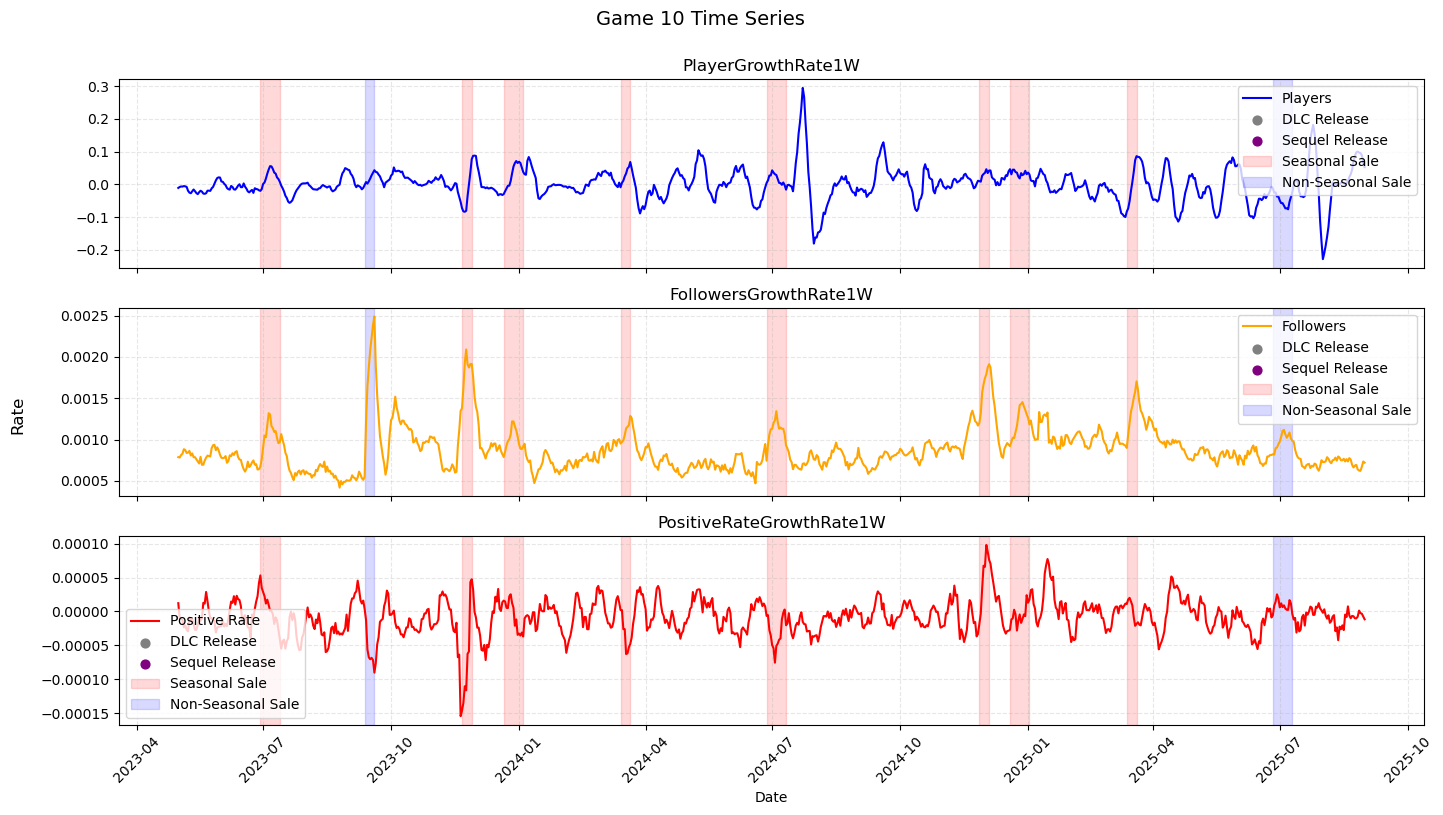

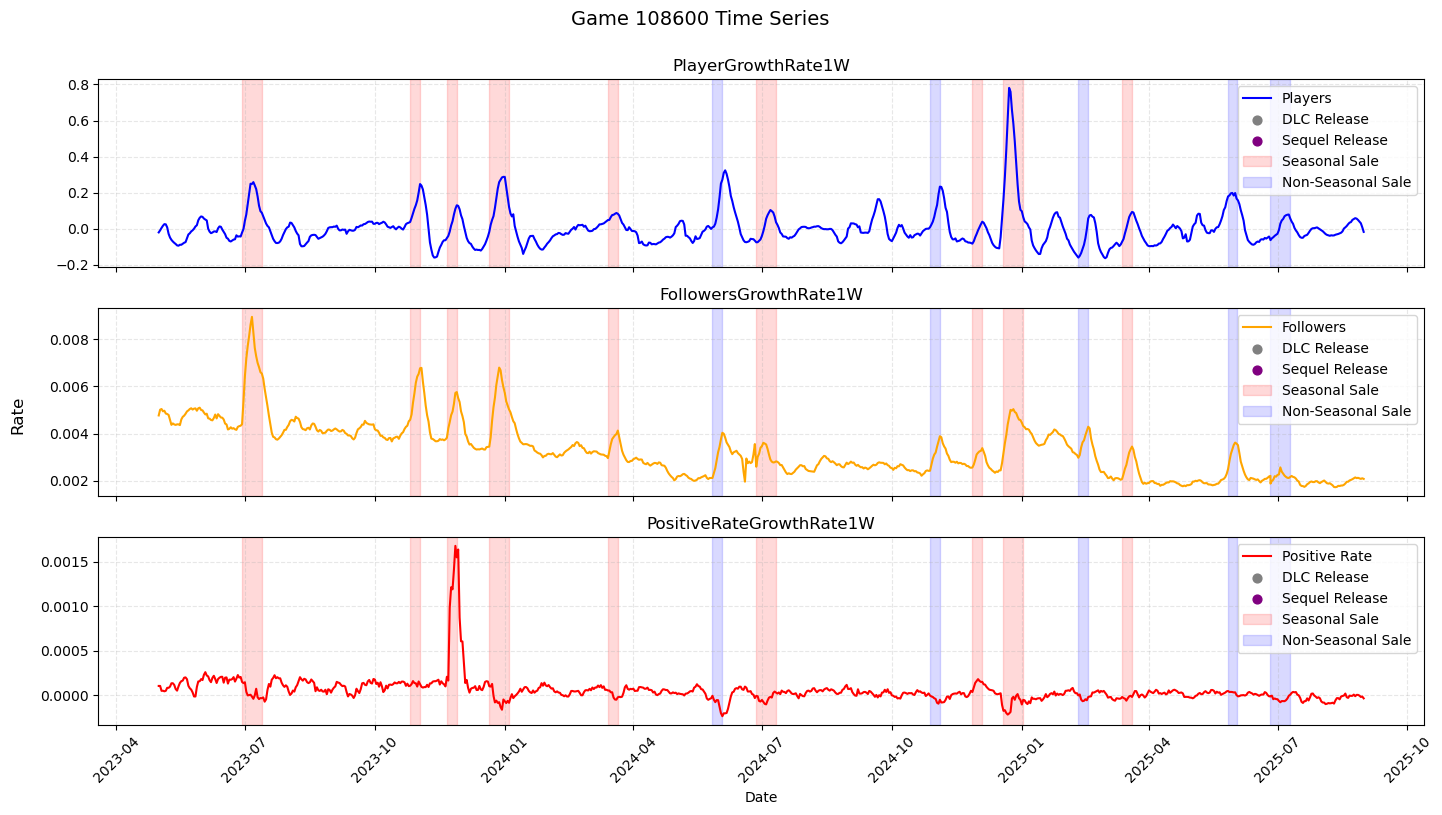

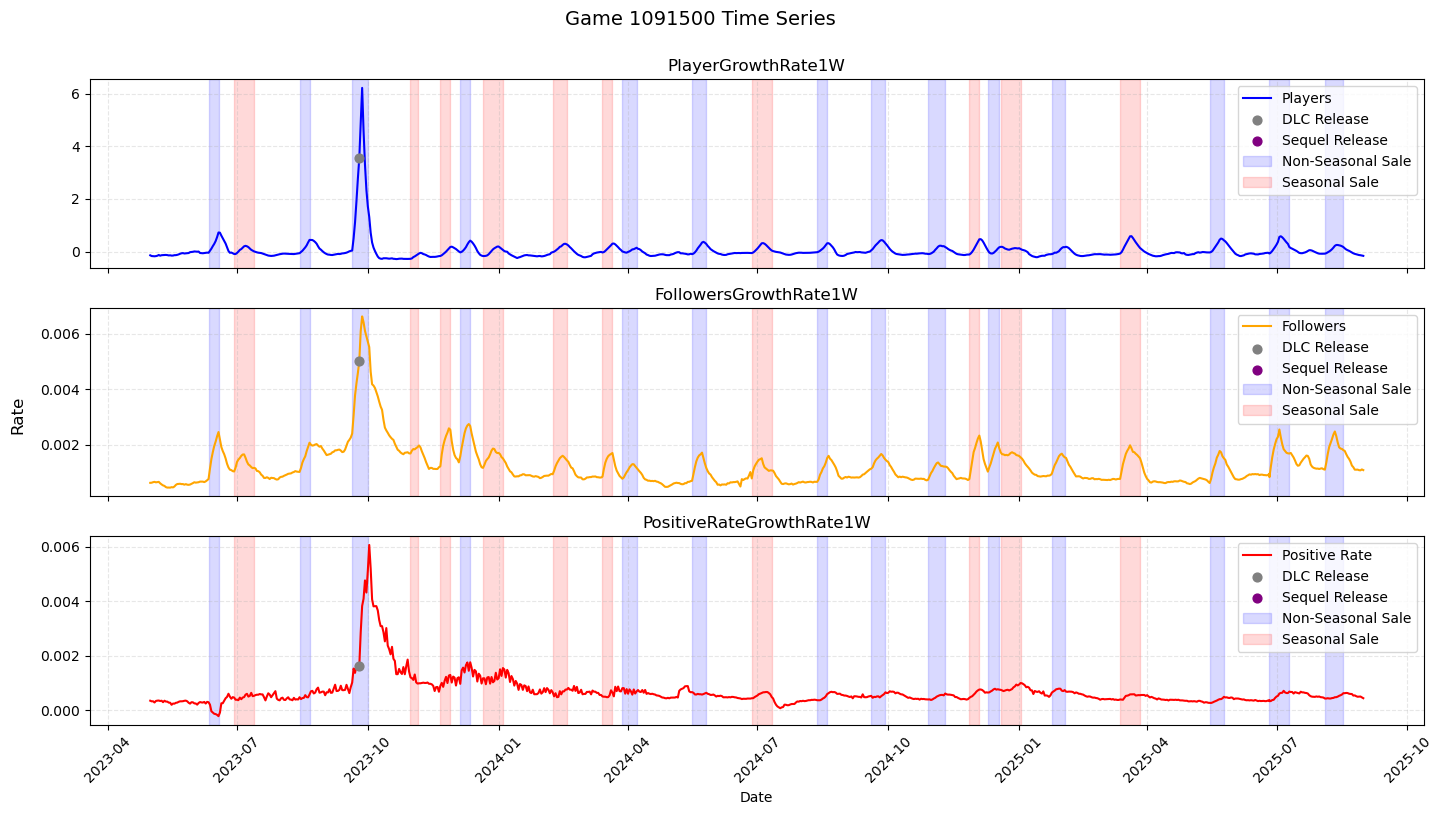

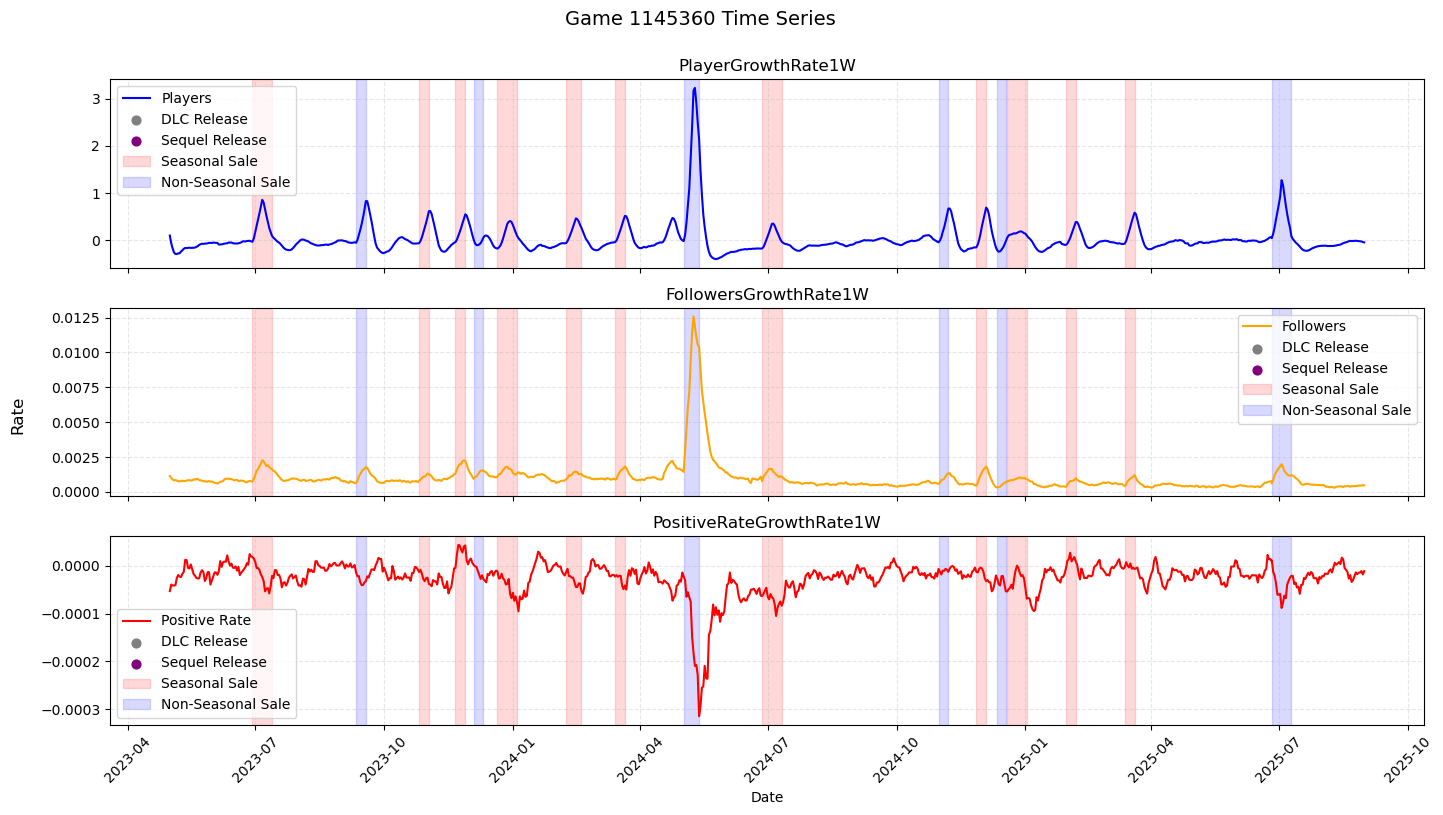

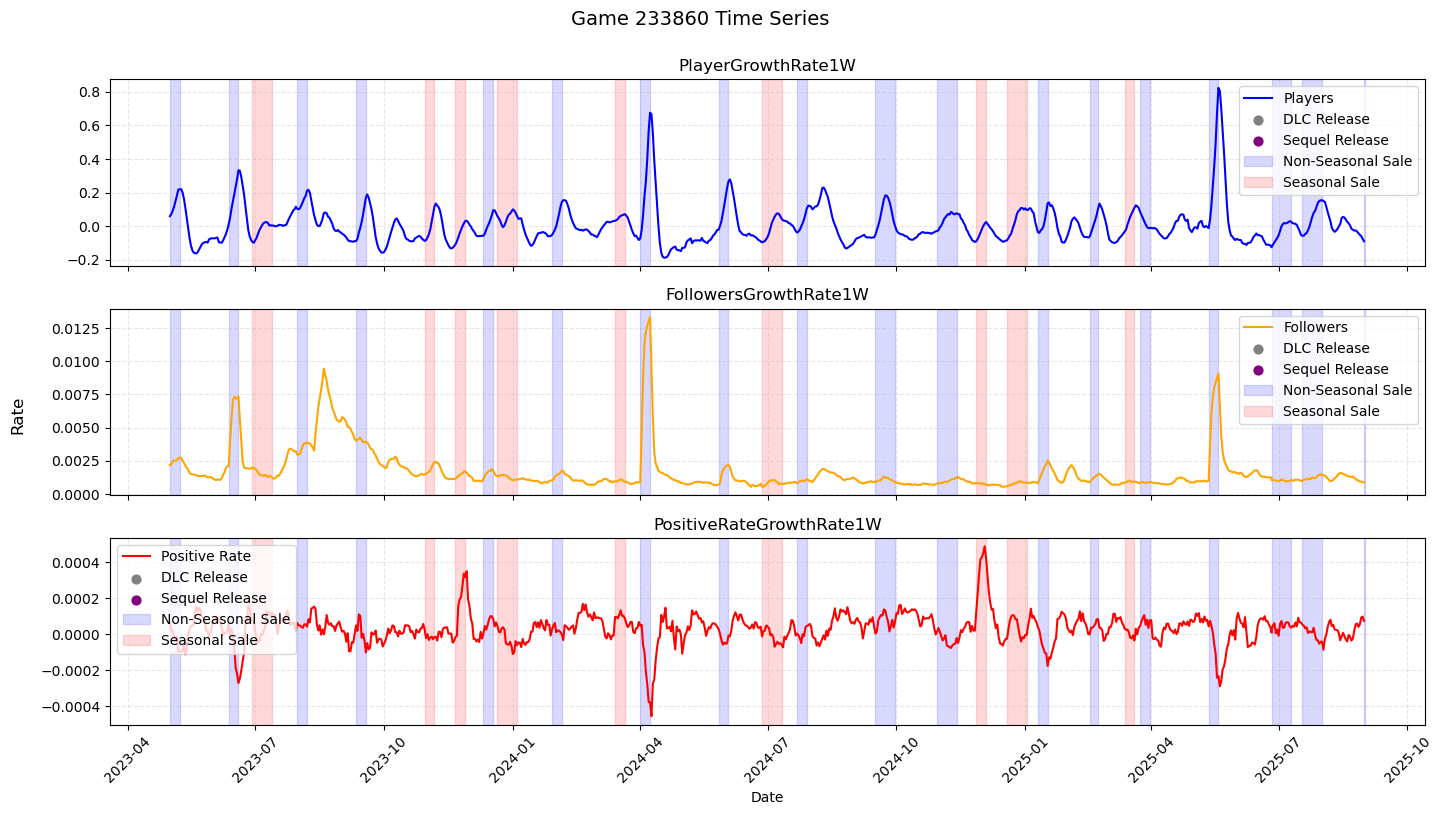

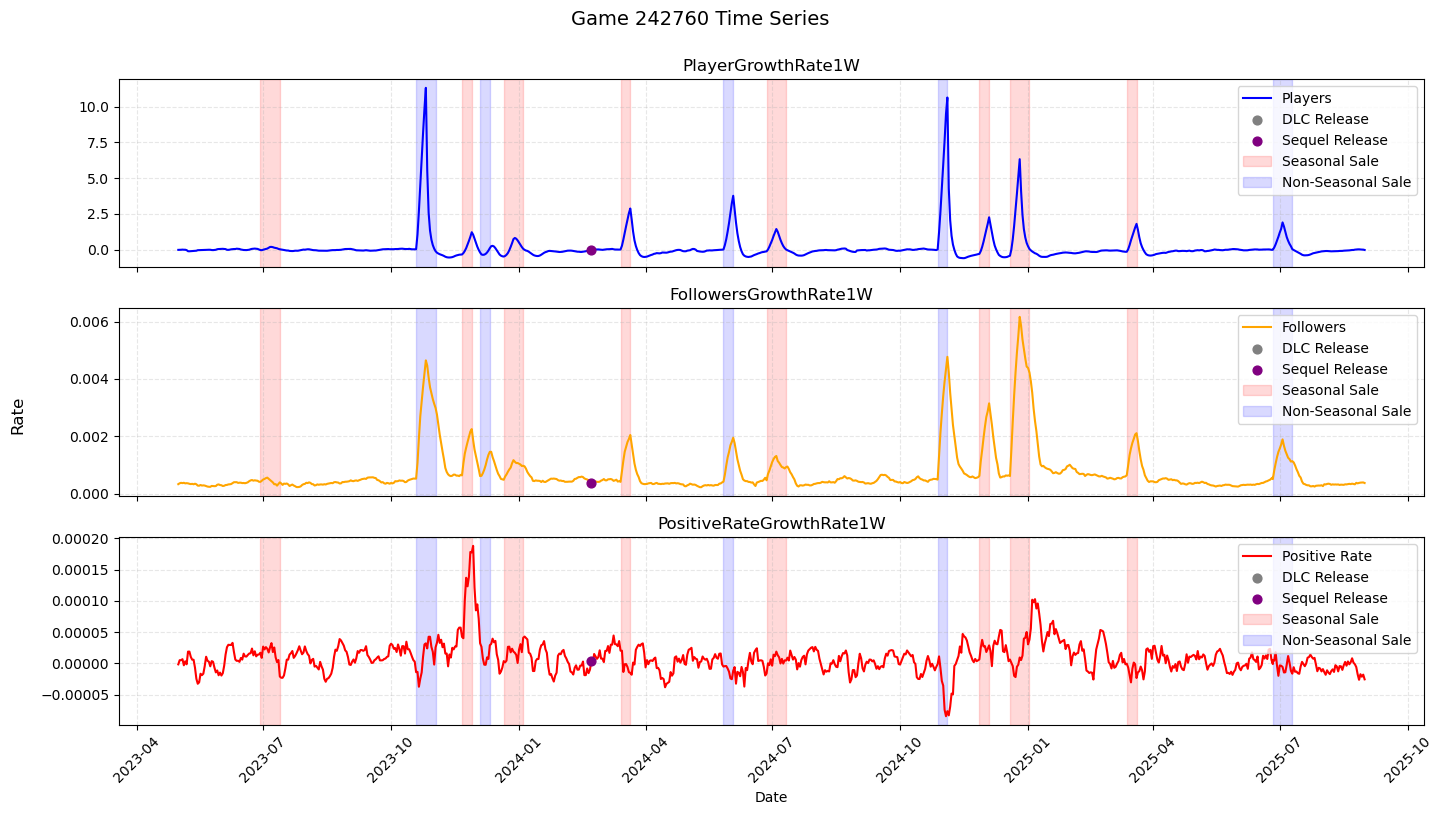

In [75]:
for index, sub_df in enumerate(game_dfs):
    dlc_first_day = sub_df[
        (sub_df['DLC_sum_1W'] > 0) &
        (sub_df['DLC_sum_1W'].shift(1) == sub_df['DLC_sum_1W'] - 1)
    ]

    sequel_first_day = sub_df[
        (sub_df['Sequel_sum_1W'] > 0) &
        (sub_df['Sequel_sum_1W'].shift(1) == sub_df['Sequel_sum_1W'] - 1)
    ]
    fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

    # ---- 大圖標題 & 全圖Y軸標籤 ----
    gid = sub_df['GameID'].iloc[0]  # 假設每個sub_df都有GameID欄位
    fig.suptitle(f'Game {gid} Time Series', fontsize=14, y=0.95)  # 給整張圖標題
    fig.text(0.04, 0.5, 'Rate', va='center', rotation='vertical', fontsize=12)  # 給整張圖的y軸標籤

    # ---- 各子圖 ----
    axes[0].plot(sub_df['Date'], sub_df['PlayerGrowthRate1W'], label='Players', color='blue')
    axes[0].set_title('PlayerGrowthRate1W')
    axes[0].scatter(dlc_first_day['Date'],
                    dlc_first_day['PlayerGrowthRate1W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[0].scatter(sequel_first_day['Date'],
                    sequel_first_day['PlayerGrowthRate1W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[1].plot(sub_df['Date'], sub_df['FollowersGrowthRate1W'], label='Followers', color='orange')
    axes[1].set_title('FollowersGrowthRate1W')
    axes[1].scatter(dlc_first_day['Date'],
                    dlc_first_day['FollowersGrowthRate1W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[1].scatter(sequel_first_day['Date'],
                    sequel_first_day['FollowersGrowthRate1W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[2].plot(sub_df['Date'], sub_df['PositiveRateGrowthRate1W'], label='Positive Rate', color='red')
    axes[2].set_title('PositiveRateGrowthRate1W')
    axes[2].scatter(dlc_first_day['Date'],
                    dlc_first_day['PositiveRateGrowthRate1W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[2].scatter(sequel_first_day['Date'],
                    sequel_first_day['PositiveRateGrowthRate1W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)


    # ---- 標記打折期間 ----
    sale_labels = {'Seasonal Sale': False, 'Non-Seasonal Sale': False}

    for _, row in sub_df.iterrows():
        if row['DiscountOrNot'] == 1:
            start_date = row['Date']
            end_date = row['Date'] + timedelta(days=row['DiscountDuration'])

            # 判斷季節/非季節折扣
            if row['SalePeriod'] == 1:
                color = 'red'
                label = 'Seasonal Sale'
            else:
                color = 'blue'
                label = 'Non-Seasonal Sale'

            # 只讓第一次出現的區間加上 label
            for ax in axes:
                ax.axvspan(start_date, end_date, color=color, alpha=0.15,
                        label=label if not sale_labels[label] else None)

            sale_labels[label] = True


        

    # ---- 共用設定 ----
    for ax in axes:
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # 保留空間給標題和y標籤
    plt.show()

    if index == 5:
        break
    



#### 打折的前後趨勢對比

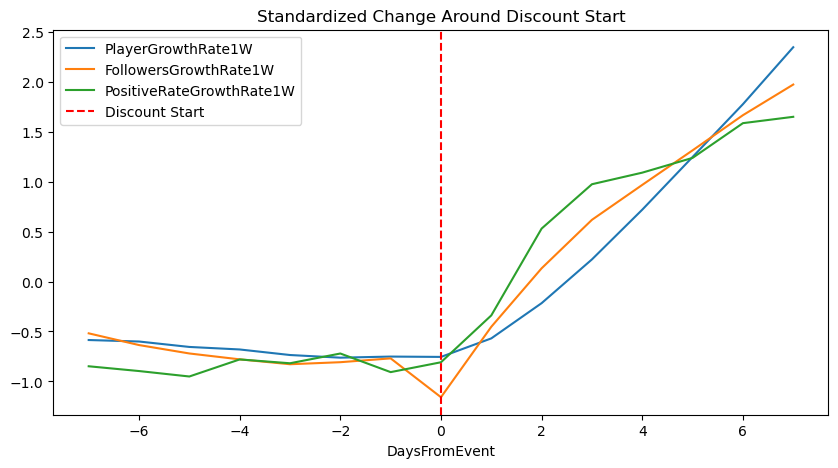

In [60]:
window = 7
event_data = []

for _, row in df[df['DiscountOrNot'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


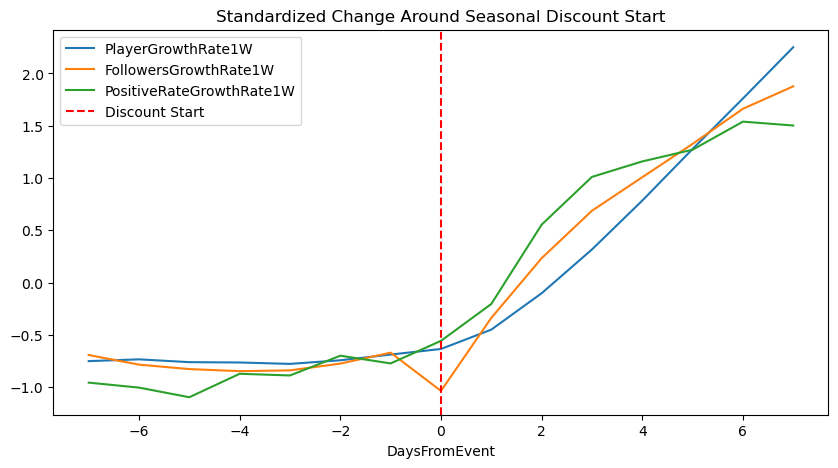

In [88]:
window = 7
event_data = []

for _, row in df[df['DiscountDuringSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


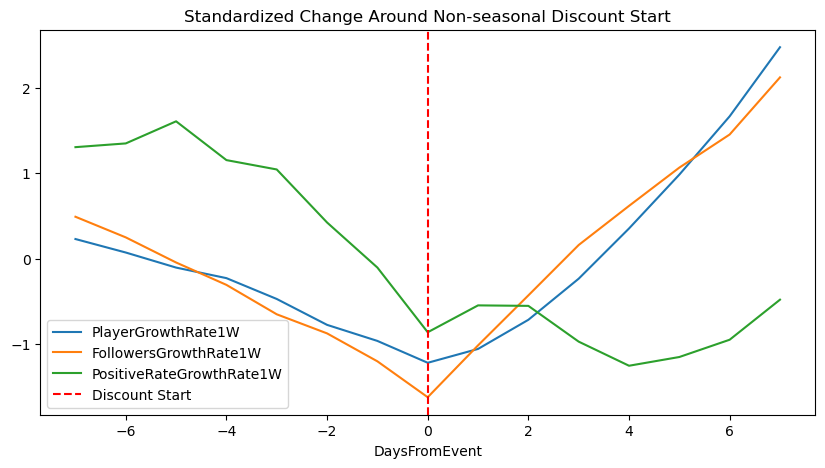

In [65]:
window = 7
event_data = []

for _, row in df[df['DiscountOutOfSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Non-seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


## 2W

#### 時間序列圖

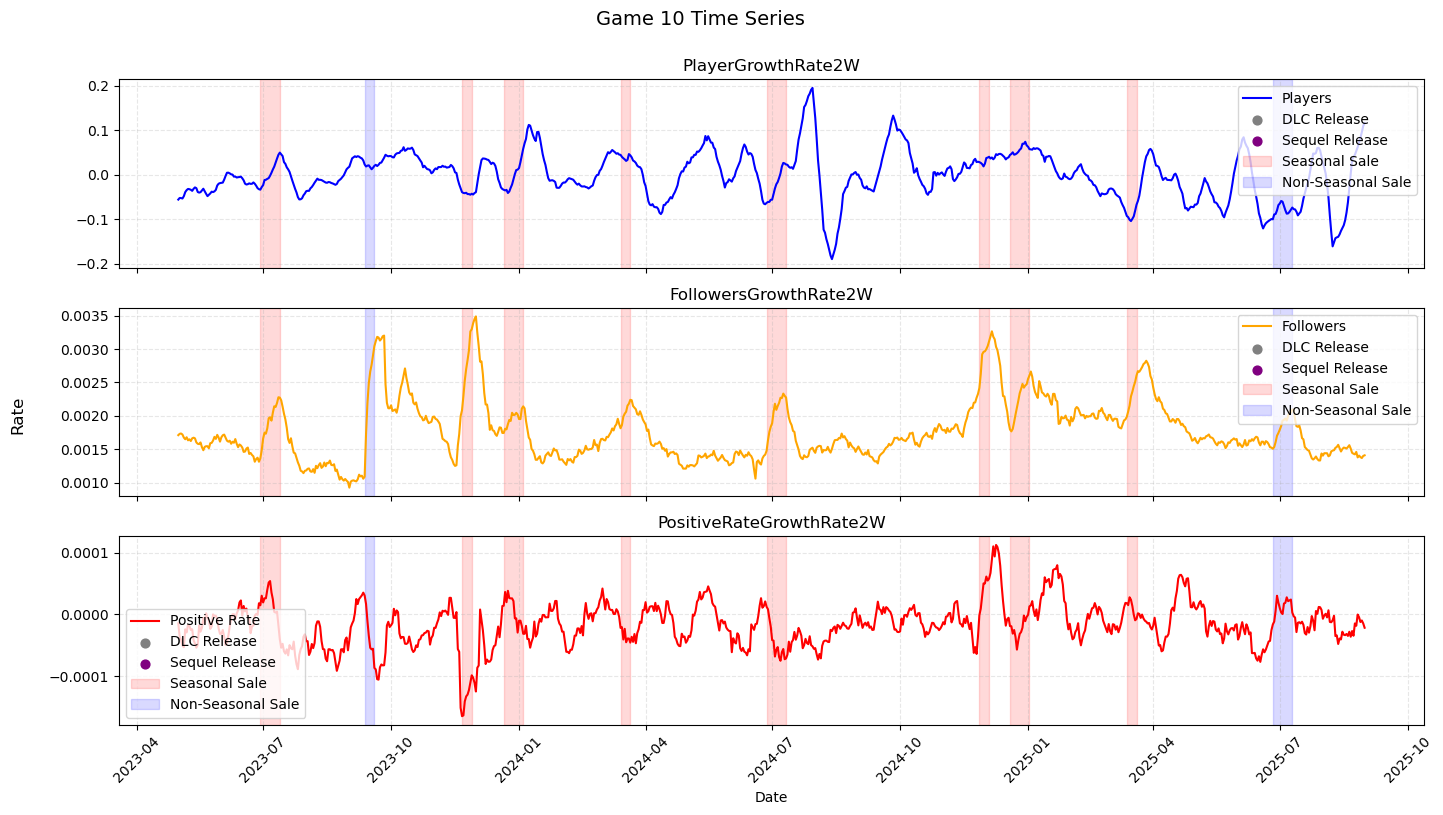

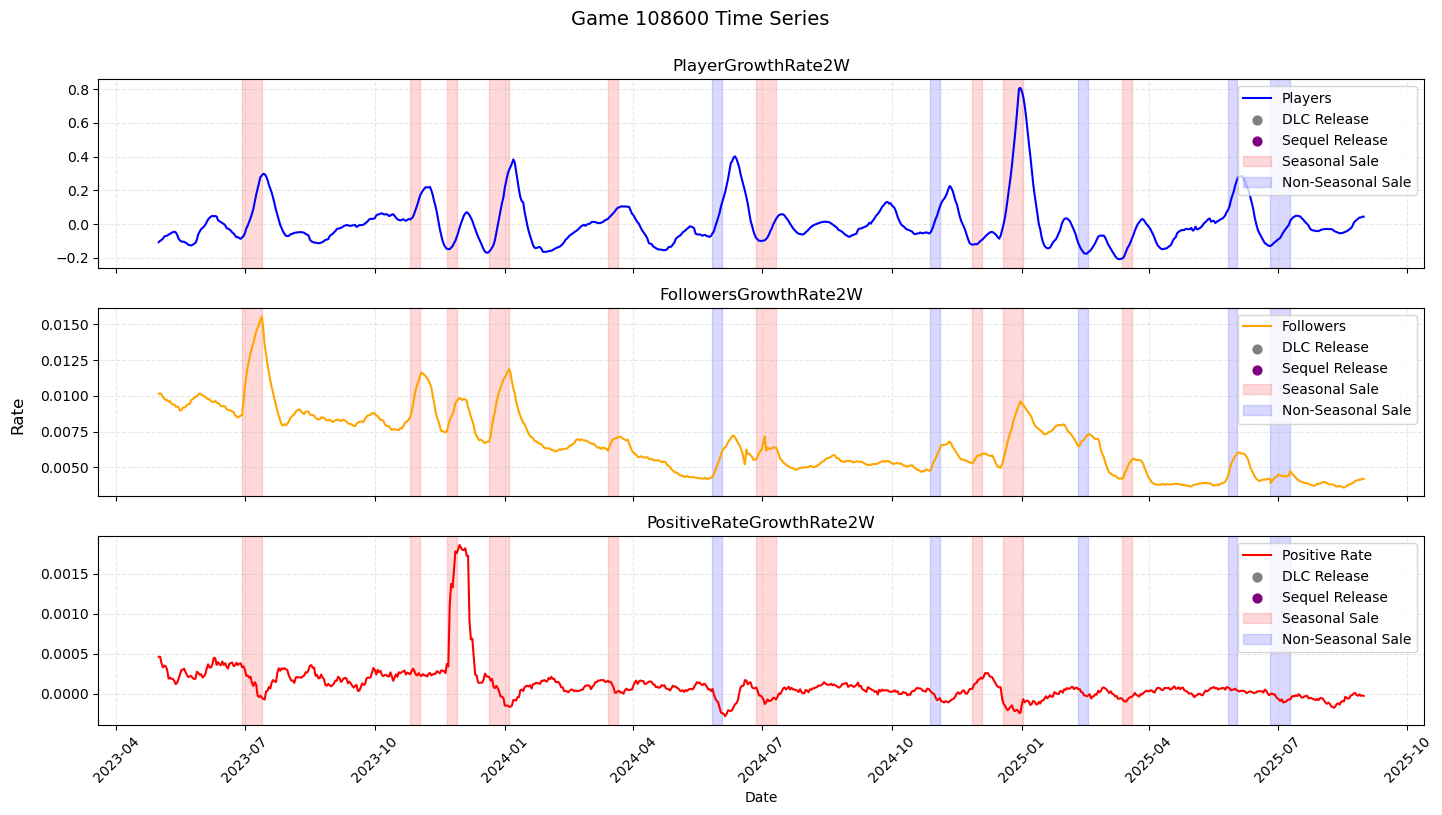

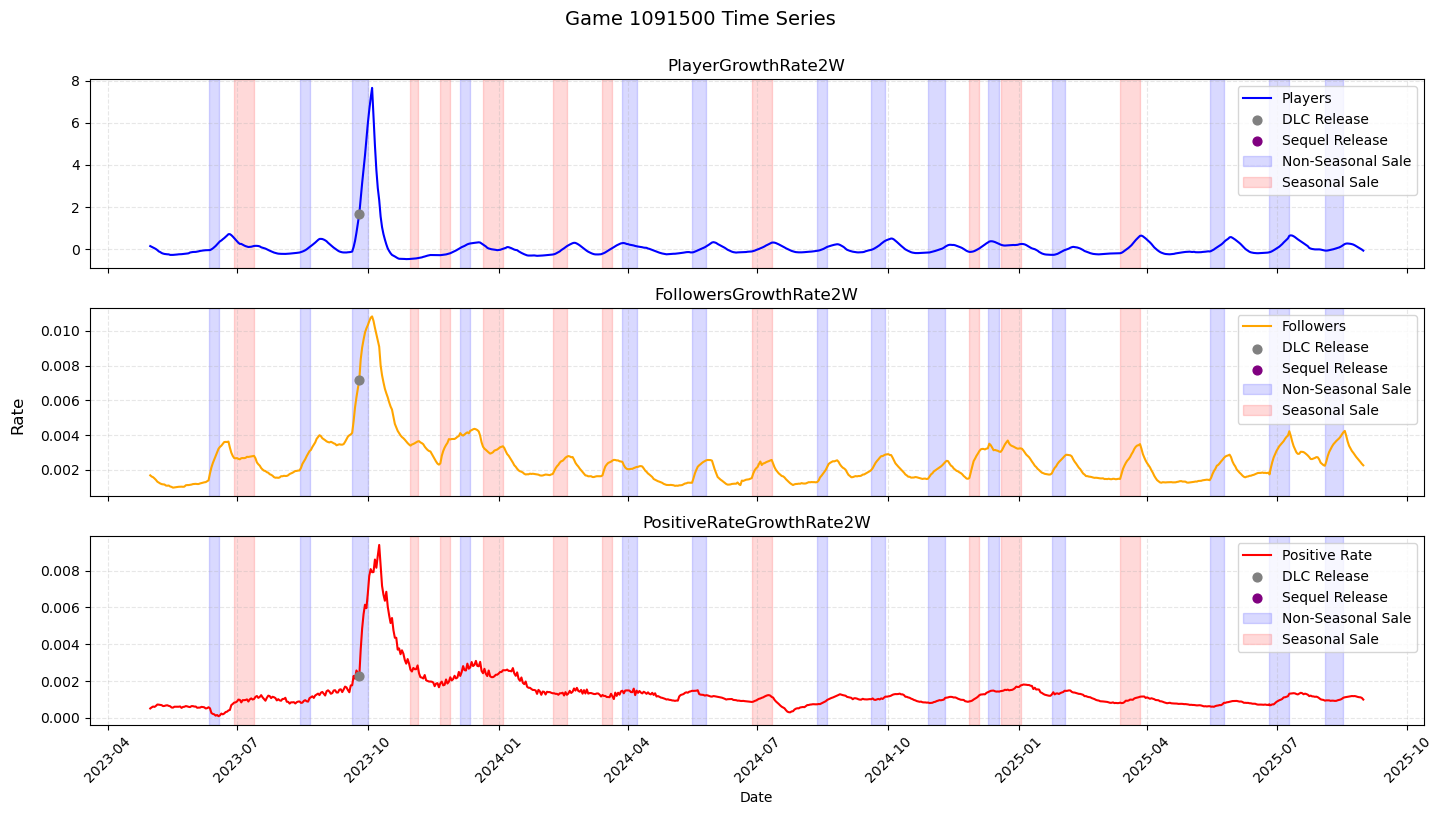

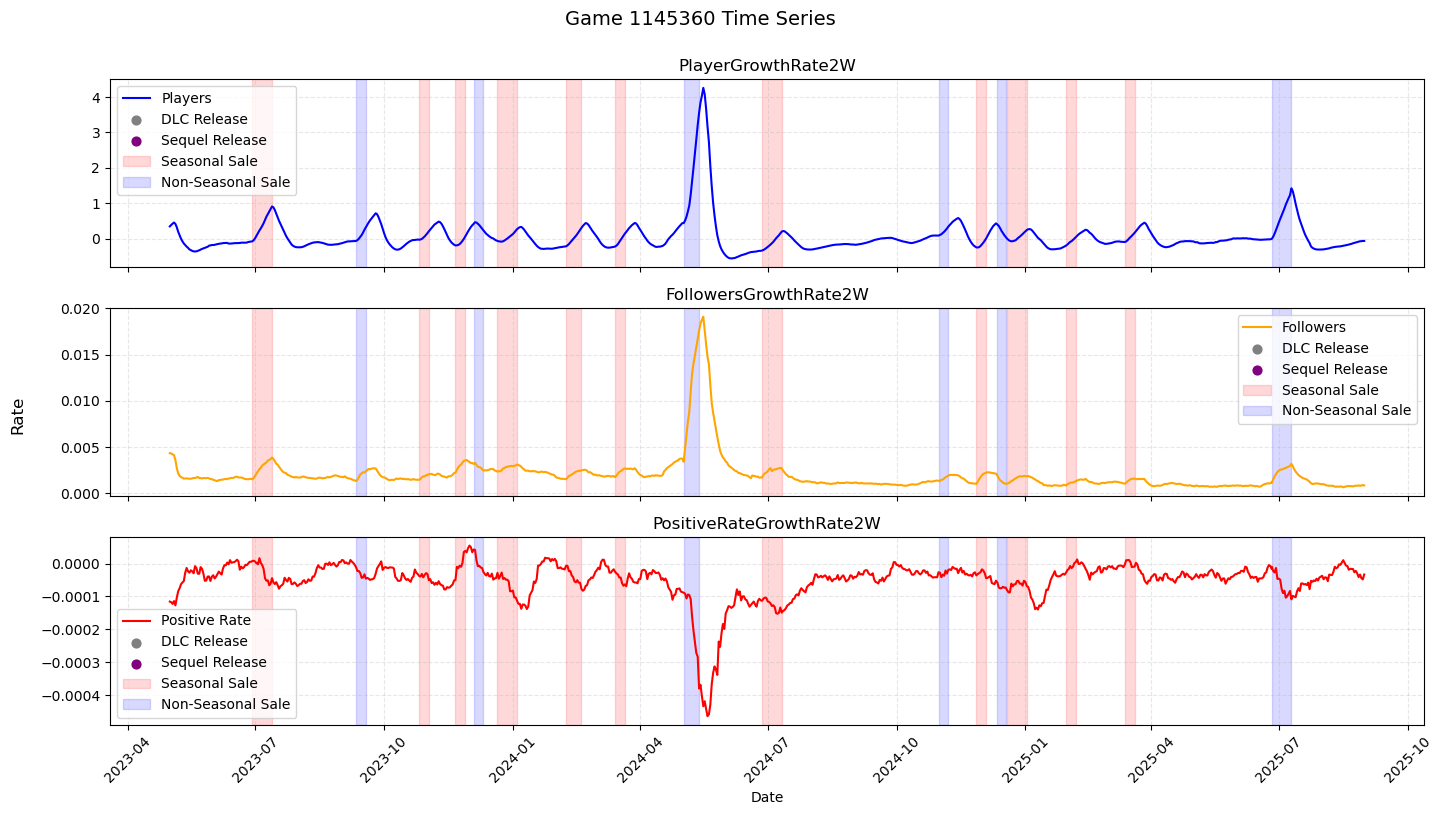

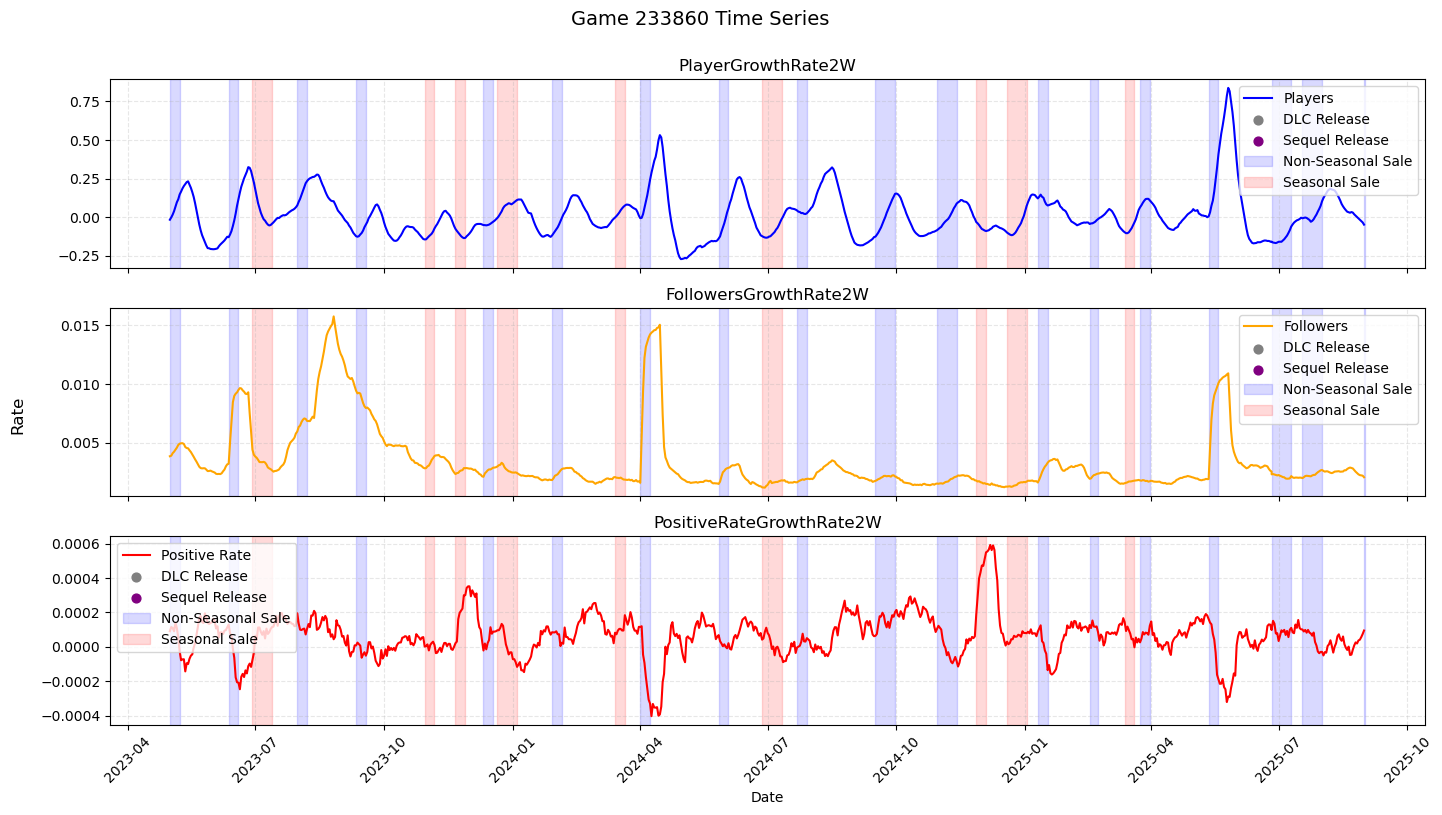

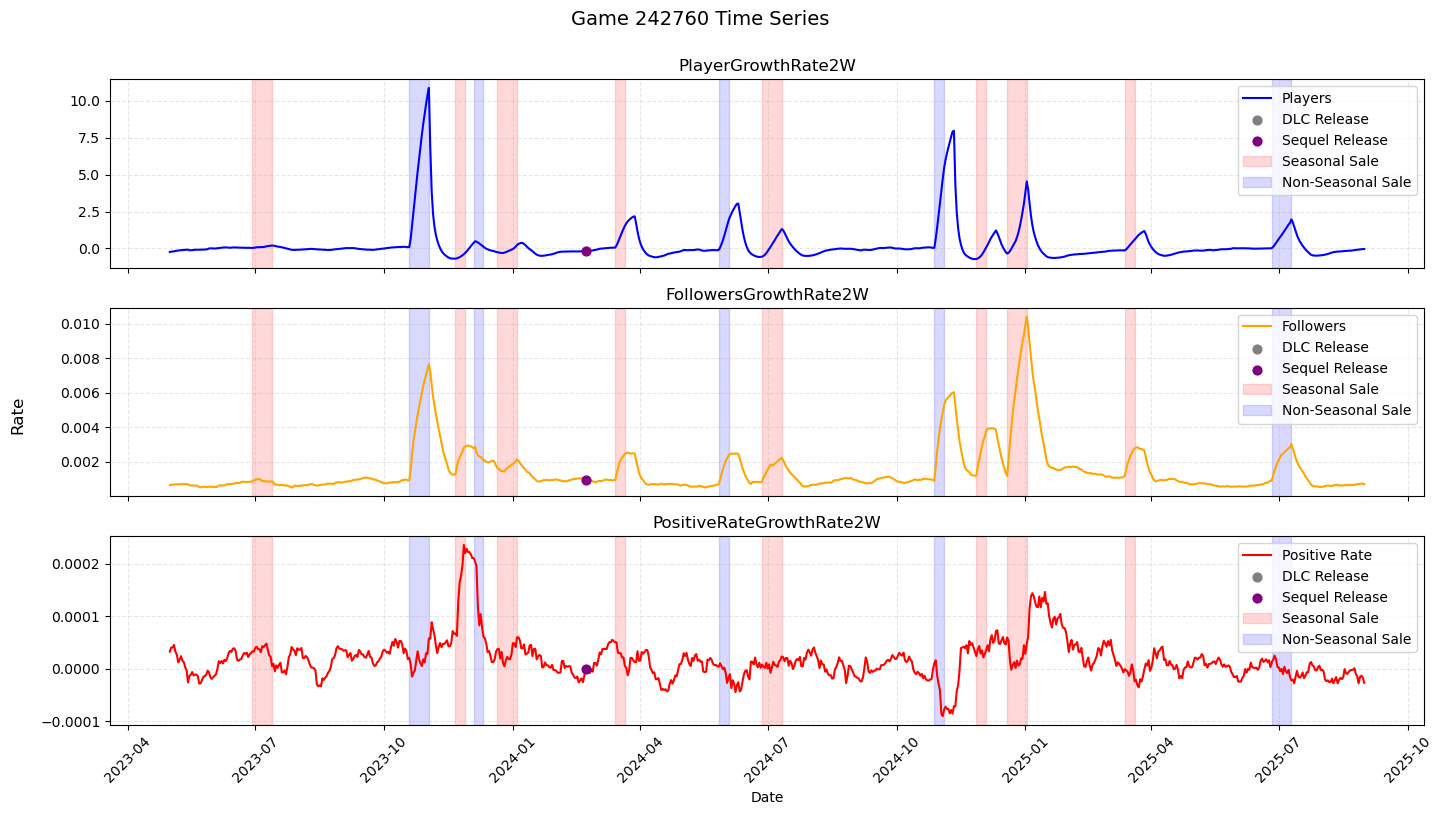

In [54]:
for index, sub_df in enumerate(game_dfs):
    dlc_first_day = sub_df[
        (sub_df['DLC_sum_1W'] == 1) &
        (sub_df['DLC_sum_1W'].shift(1) != 1)
    ]

    sequel_first_day = sub_df[
        (sub_df['Sequel_sum_1W'] == 1) &
        (sub_df['Sequel_sum_1W'].shift(1) != 1)
    ]
    fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

    # ---- 大圖標題 & 全圖Y軸標籤 ----
    gid = sub_df['GameID'].iloc[0]  # 假設每個sub_df都有GameID欄位
    fig.suptitle(f'Game {gid} Time Series', fontsize=14, y=0.95)  # 給整張圖標題
    fig.text(0.04, 0.5, 'Rate', va='center', rotation='vertical', fontsize=12)  # 給整張圖的y軸標籤

    # ---- 各子圖 ----
    axes[0].plot(sub_df['Date'], sub_df['PlayerGrowthRate2W'], label='Players', color='blue')
    axes[0].set_title('PlayerGrowthRate2W')
    axes[0].scatter(dlc_first_day['Date'],
                    dlc_first_day['PlayerGrowthRate2W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[0].scatter(sequel_first_day['Date'],
                    sequel_first_day['PlayerGrowthRate2W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[1].plot(sub_df['Date'], sub_df['FollowersGrowthRate2W'], label='Followers', color='orange')
    axes[1].set_title('FollowersGrowthRate2W')
    axes[1].scatter(dlc_first_day['Date'],
                    dlc_first_day['FollowersGrowthRate2W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[1].scatter(sequel_first_day['Date'],
                    sequel_first_day['FollowersGrowthRate2W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[2].plot(sub_df['Date'], sub_df['PositiveRateGrowthRate2W'], label='Positive Rate', color='red')
    axes[2].set_title('PositiveRateGrowthRate2W')
    axes[2].scatter(dlc_first_day['Date'],
                    dlc_first_day['PositiveRateGrowthRate2W'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[2].scatter(sequel_first_day['Date'],
                    sequel_first_day['PositiveRateGrowthRate2W'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)


    # ---- 標記打折期間 ----
    sale_labels = {'Seasonal Sale': False, 'Non-Seasonal Sale': False}

    for _, row in sub_df.iterrows():
        if row['DiscountOrNot'] == 1:
            start_date = row['Date']
            end_date = row['Date'] + timedelta(days=row['DiscountDuration'])

            # 判斷季節/非季節折扣
            if row['SalePeriod'] == 1:
                color = 'red'
                label = 'Seasonal Sale'
            else:
                color = 'blue'
                label = 'Non-Seasonal Sale'

            # 只讓第一次出現的區間加上 label
            for ax in axes:
                ax.axvspan(start_date, end_date, color=color, alpha=0.15,
                        label=label if not sale_labels[label] else None)

            sale_labels[label] = True


        

    # ---- 共用設定 ----
    for ax in axes:
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # 保留空間給標題和y標籤
    plt.show()
    if index == 5:
        break



#### 打折的前後趨勢對比

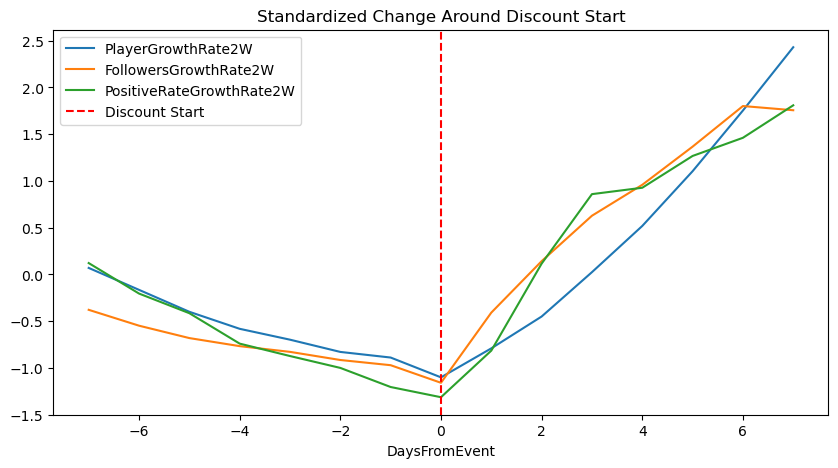

In [87]:
window = 7
event_data = []

for _, row in df[df['DiscountOrNot'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate2W', 'FollowersGrowthRate2W', 'PositiveRateGrowthRate2W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


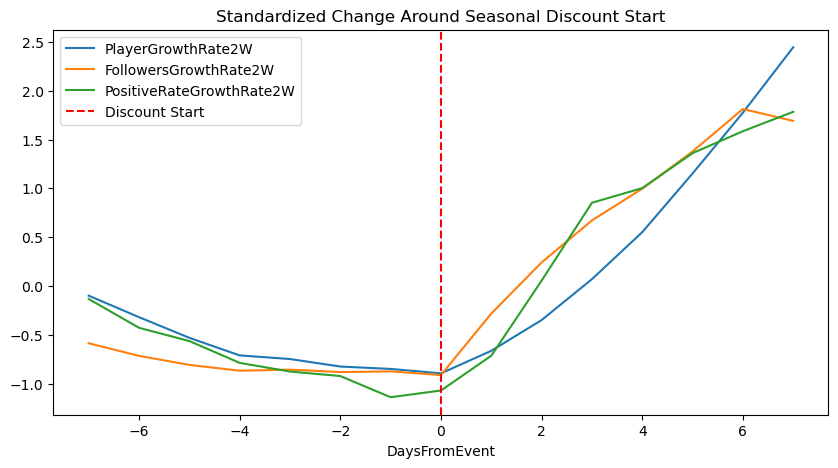

In [86]:
window = 7
event_data = []

for _, row in df[df['DiscountDuringSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate2W', 'FollowersGrowthRate2W', 'PositiveRateGrowthRate2W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


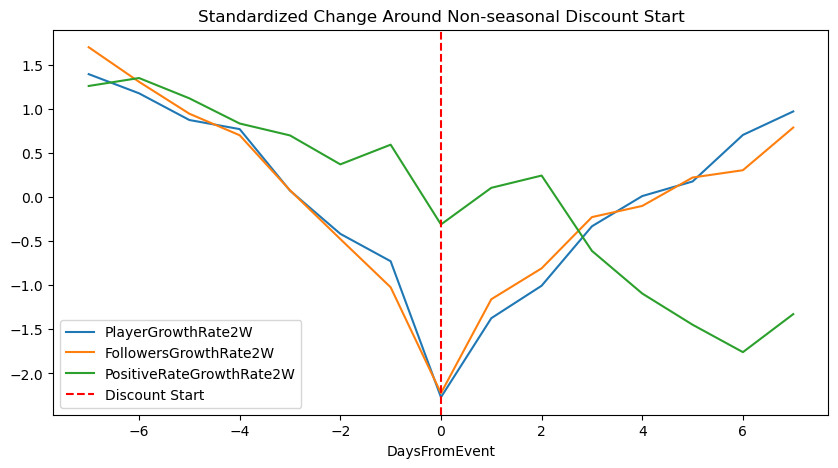

In [85]:
window = 7
event_data = []

for _, row in df[df['DiscountOutOfSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate2W', 'FollowersGrowthRate2W', 'PositiveRateGrowthRate2W']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Non-seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


## 1M

#### 時間序列圖

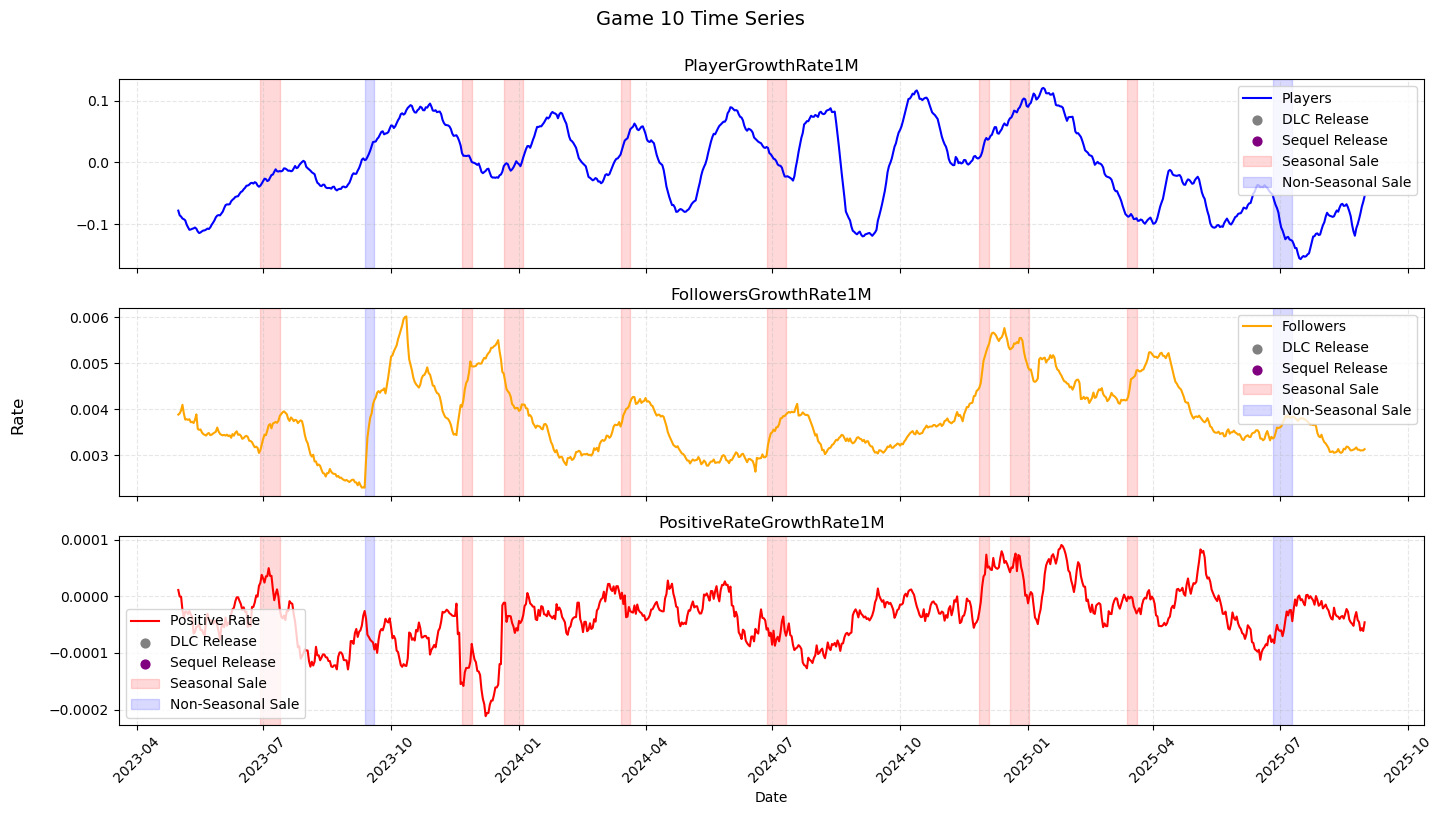

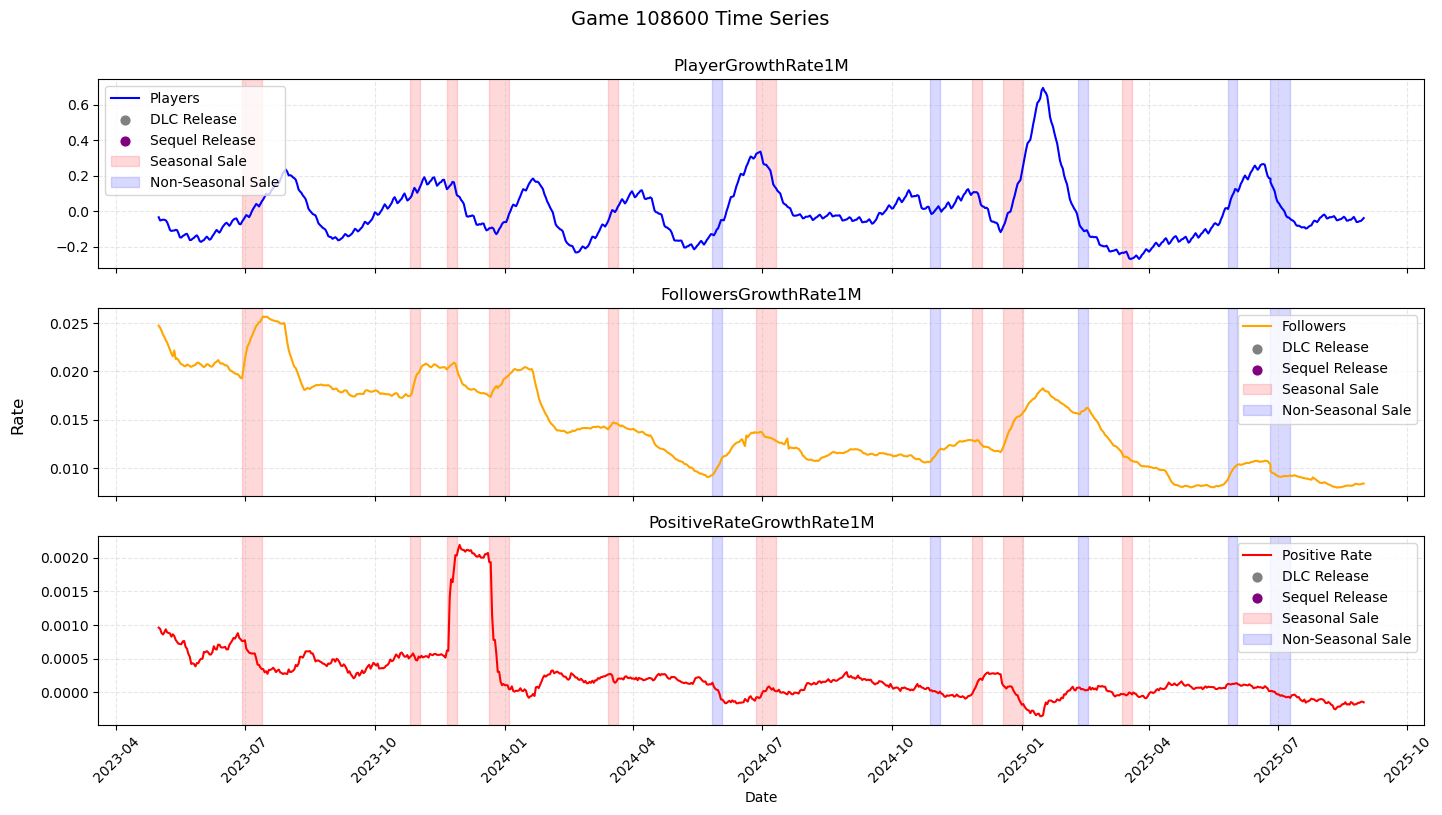

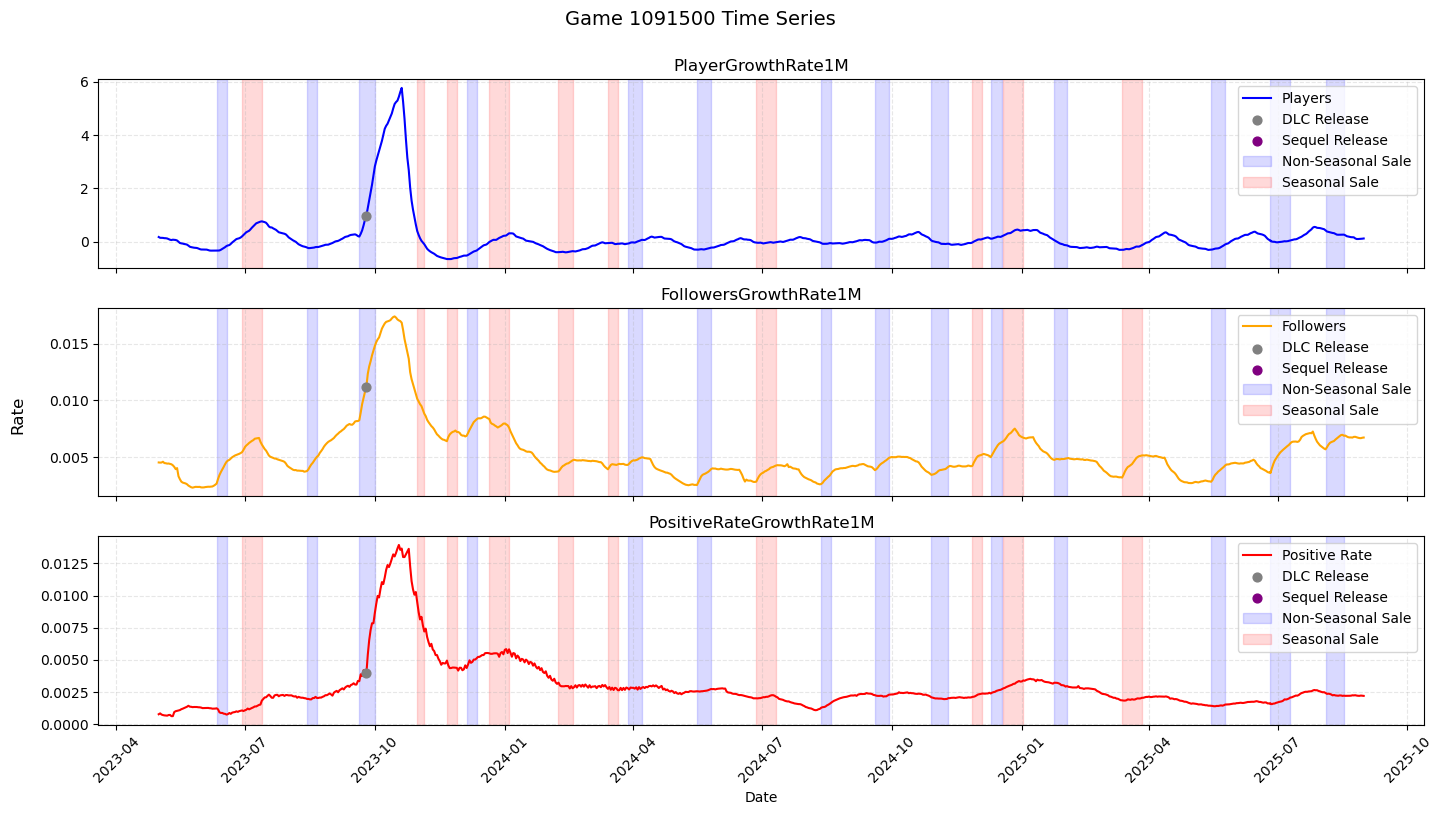

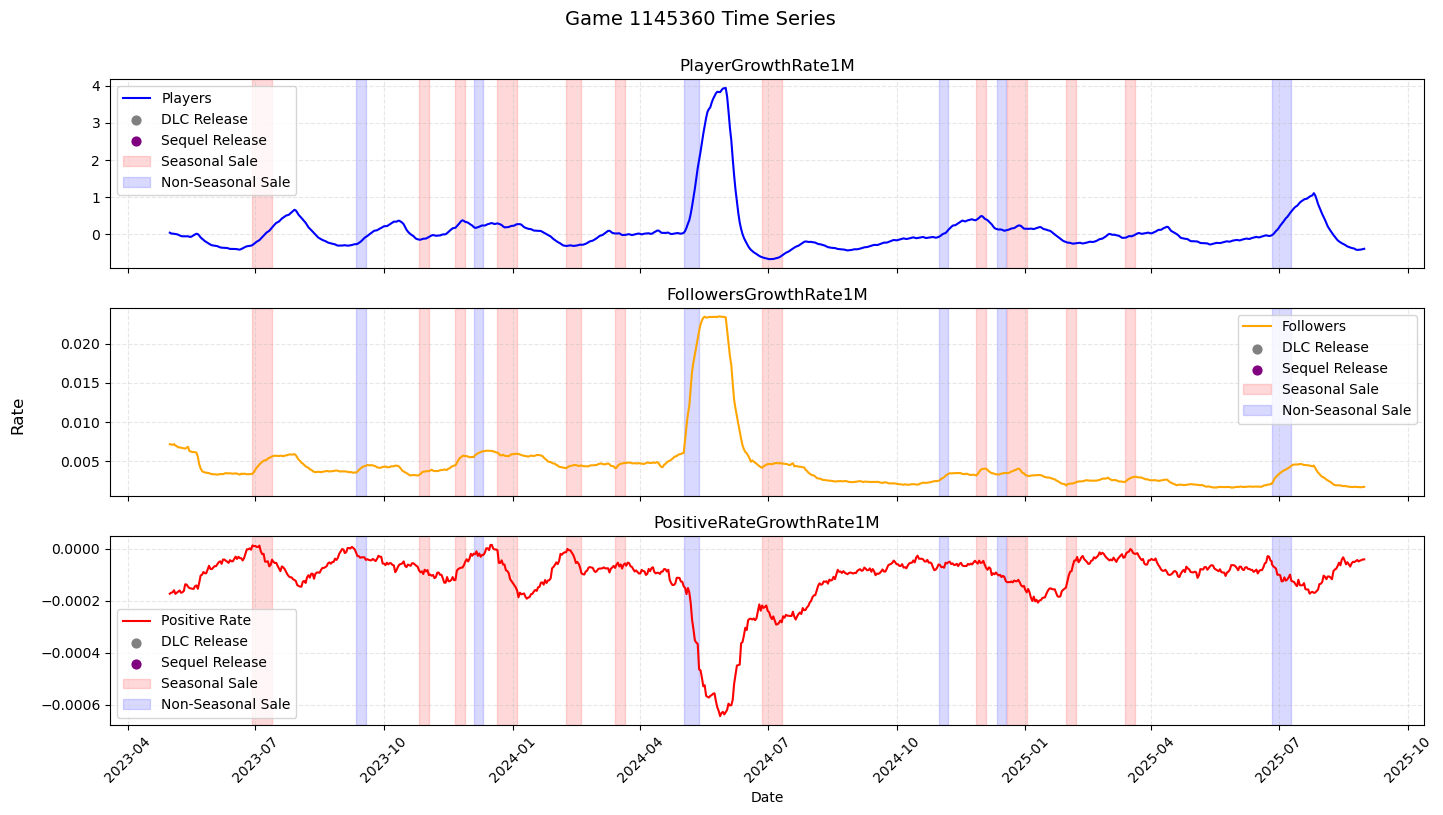

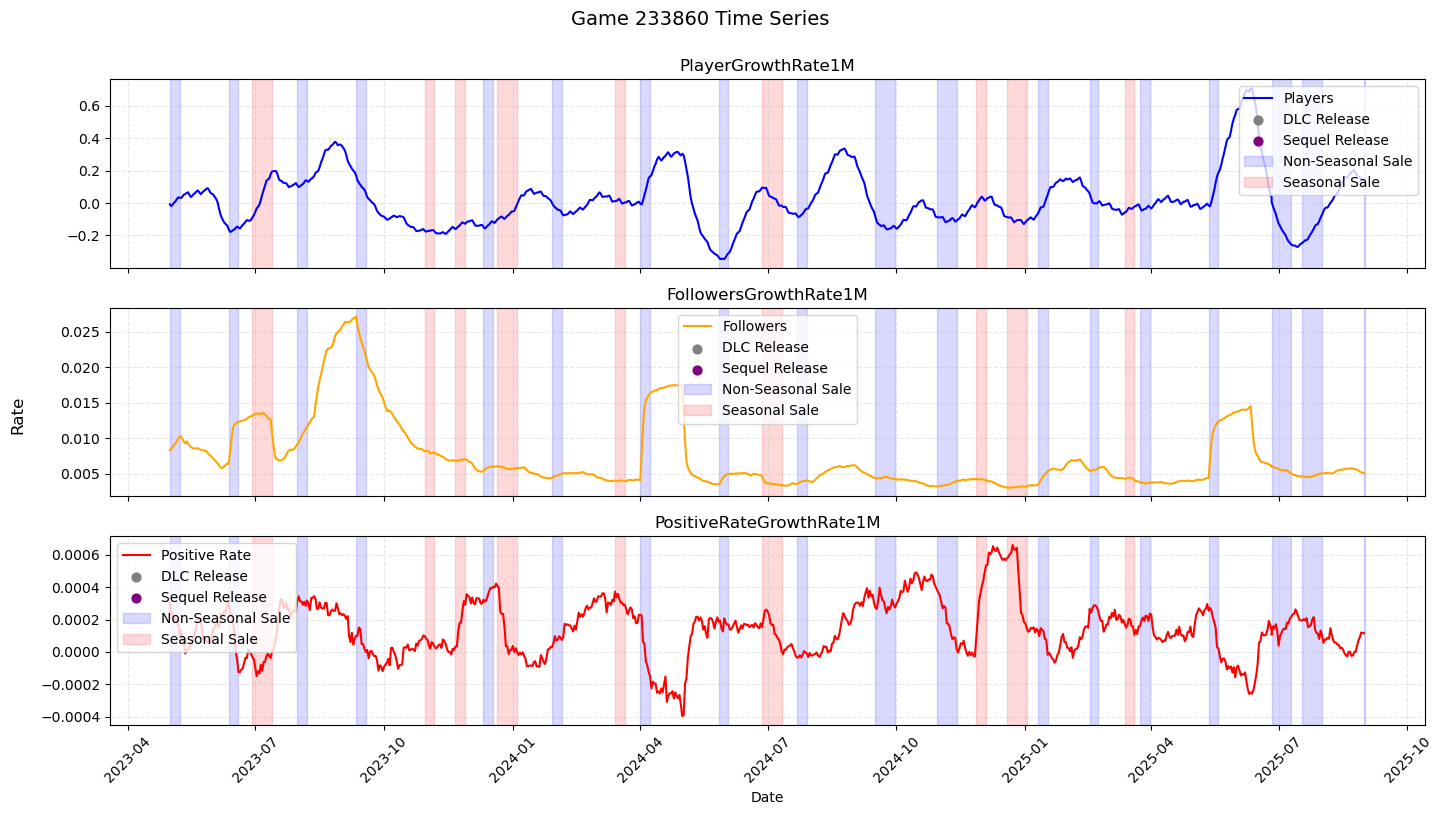

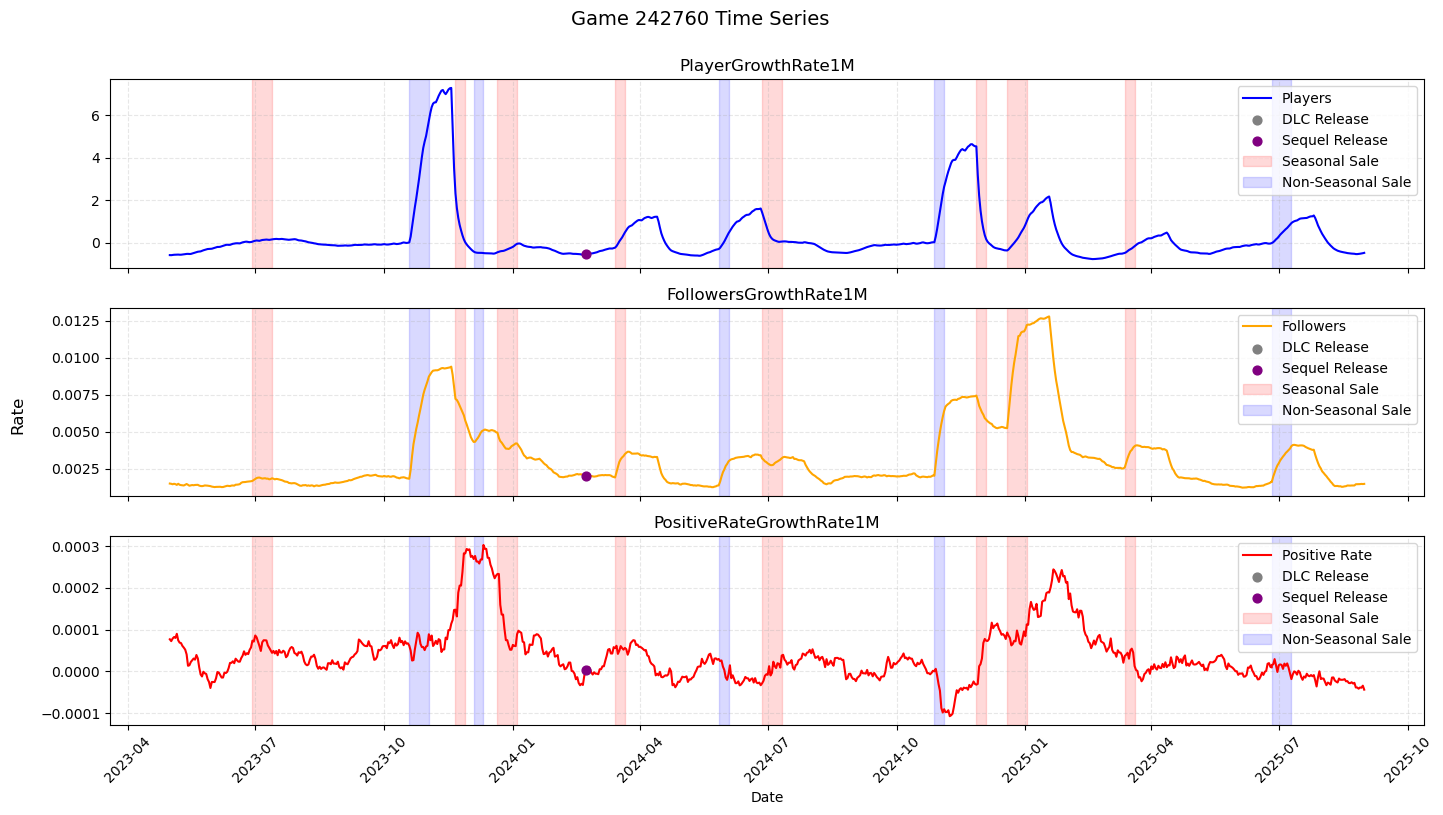

In [55]:
for index, sub_df in enumerate(game_dfs):
    dlc_first_day = sub_df[
        (sub_df['DLC_sum_1W'] == 1) &
        (sub_df['DLC_sum_1W'].shift(1) != 1)
    ]

    sequel_first_day = sub_df[
        (sub_df['Sequel_sum_1W'] == 1) &
        (sub_df['Sequel_sum_1W'].shift(1) != 1)
    ]
    fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

    # ---- 大圖標題 & 全圖Y軸標籤 ----
    gid = sub_df['GameID'].iloc[0]  # 假設每個sub_df都有GameID欄位
    fig.suptitle(f'Game {gid} Time Series', fontsize=14, y=0.95)  # 給整張圖標題
    fig.text(0.04, 0.5, 'Rate', va='center', rotation='vertical', fontsize=12)  # 給整張圖的y軸標籤

    # ---- 各子圖 ----
    axes[0].plot(sub_df['Date'], sub_df['PlayerGrowthRate1M'], label='Players', color='blue')
    axes[0].set_title('PlayerGrowthRate1M')
    axes[0].scatter(dlc_first_day['Date'],
                    dlc_first_day['PlayerGrowthRate1M'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[0].scatter(sequel_first_day['Date'],
                    sequel_first_day['PlayerGrowthRate1M'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[1].plot(sub_df['Date'], sub_df['FollowersGrowthRate1M'], label='Followers', color='orange')
    axes[1].set_title('FollowersGrowthRate1M')
    axes[1].scatter(dlc_first_day['Date'],
                    dlc_first_day['FollowersGrowthRate1M'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[1].scatter(sequel_first_day['Date'],
                    sequel_first_day['FollowersGrowthRate1M'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)

    axes[2].plot(sub_df['Date'], sub_df['PositiveRateGrowthRate1M'], label='Positive Rate', color='red')
    axes[2].set_title('PositiveRateGrowthRate1M')
    axes[2].scatter(dlc_first_day['Date'],
                    dlc_first_day['PositiveRateGrowthRate1M'],
                    color='gray', s=40, marker='o', label='DLC Release', zorder=5)
    axes[2].scatter(sequel_first_day['Date'],
                    sequel_first_day['PositiveRateGrowthRate1M'],
                    color='purple', s=40, marker='o', label='Sequel Release', zorder=5)
    


    # ---- 標記打折期間 ----
    sale_labels = {'Seasonal Sale': False, 'Non-Seasonal Sale': False}

    for _, row in sub_df.iterrows():
        if row['DiscountOrNot'] == 1:
            start_date = row['Date']
            end_date = row['Date'] + timedelta(days=row['DiscountDuration'])

            # 判斷季節/非季節折扣
            if row['SalePeriod'] == 1:
                color = 'red'
                label = 'Seasonal Sale'
            else:
                color = 'blue'
                label = 'Non-Seasonal Sale'

            # 只讓第一次出現的區間加上 label
            for ax in axes:
                ax.axvspan(start_date, end_date, color=color, alpha=0.15,
                        label=label if not sale_labels[label] else None)

            sale_labels[label] = True


        

    # ---- 共用設定 ----
    for ax in axes:
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # 保留空間給標題和y標籤
    plt.show()

    if index == 5:
        break
    



#### 打折的前後趨勢對比

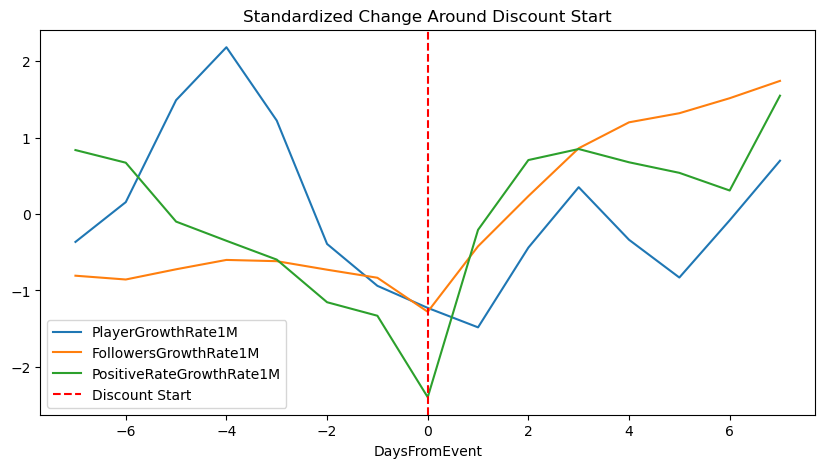

In [84]:
window = 7
event_data = []

for _, row in df[df['DiscountOrNot'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1M', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1M']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


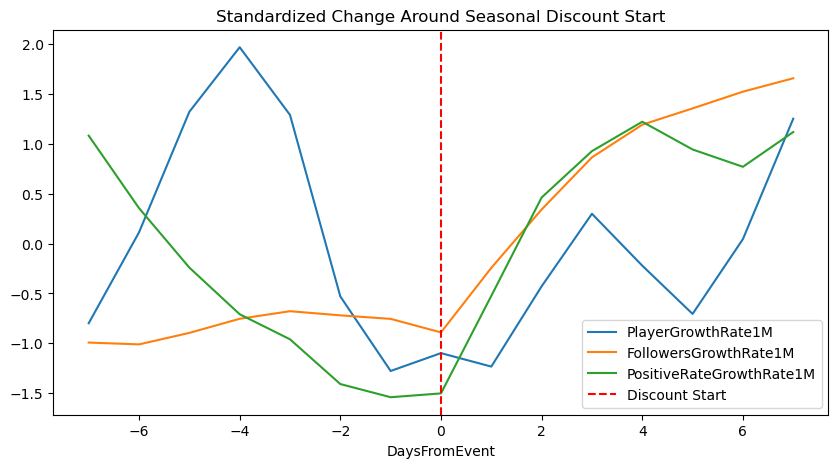

In [83]:
window = 7
event_data = []

for _, row in df[df['DiscountDuringSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1M', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1M']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


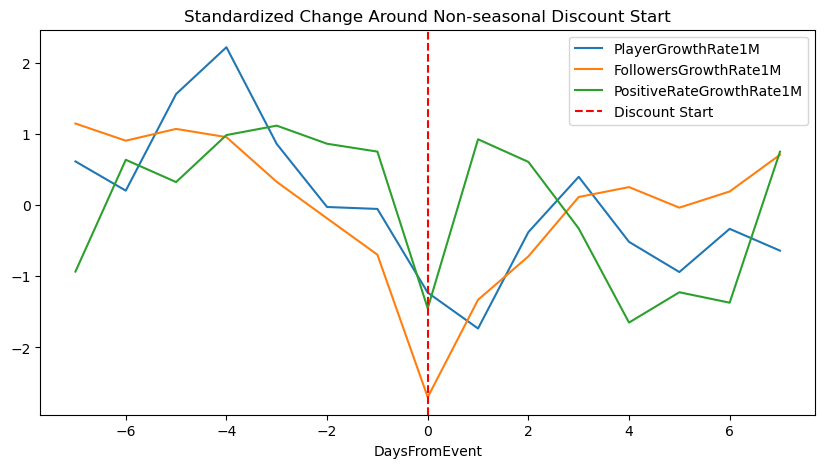

In [82]:
window = 7
event_data = []

for _, row in df[df['DiscountOutOfSale'] == 1].iterrows():
    date = row['Date']
    event_window = df[(df['Date'] >= date - pd.Timedelta(days=window)) &
                      (df['Date'] <= date + pd.Timedelta(days=window))].copy()
    event_window['DaysFromEvent'] = (event_window['Date'] - date).dt.days
    event_data.append(event_window)

event_df = pd.concat(event_data)
avg_change = event_df.groupby('DaysFromEvent')[['PlayerGrowthRate1M', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1M']].mean()

scaler = StandardScaler()
avg_change_scaled = avg_change.copy()
avg_change_scaled[:] = scaler.fit_transform(avg_change)

avg_change_scaled.plot(title='Standardized Change Around Non-seasonal Discount Start', figsize=(10,5))
plt.axvline(0, color='red', linestyle='--', label='Discount Start')
plt.legend()
plt.show()


## 其他事件對折扣影響

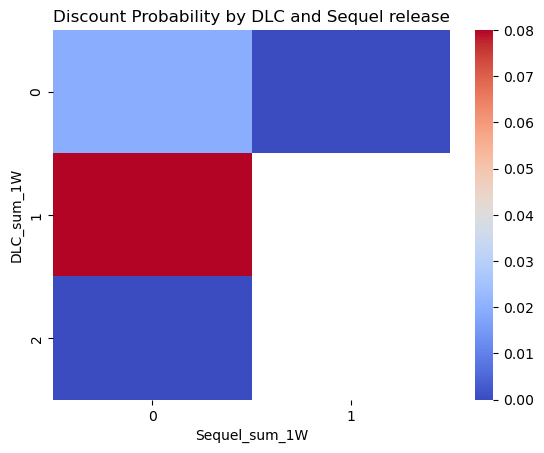

In [81]:
heatmap_data = df.groupby(['DLC_sum_1W', 'Sequel_sum_1W'])['DiscountOrNot'].mean().unstack()
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Discount Probability by DLC and Sequel release')
plt.show()

這些遊戲在我們指定的時間範圍內沒有同時發行DLC和續作，發行DLC打折的比率高於發出續作。

In [80]:
df[df['DLC_sum_1W'] == 2]

Date  GameID    Type  MultiPlayer                   Publisher  \
11890 2025-06-17  381210  Horror            1  Behaviour Interactive Inc.   
11891 2025-06-18  381210  Horror            1  Behaviour Interactive Inc.   
11892 2025-06-19  381210  Horror            1  Behaviour Interactive Inc.   
11893 2025-06-20  381210  Horror            1  Behaviour Interactive Inc.   
11894 2025-06-21  381210  Horror            1  Behaviour Interactive Inc.   
11895 2025-06-22  381210  Horror            1  Behaviour Interactive Inc.   

       ConstantDiscount  DiscountOrNot  DiscountDuration  DiscountFreq3M  \
11890                 0              0                 0               3   
11891                 0              0                 0               3   
11892                 0              0                 0               3   
11893                 0              0                 0               3   
11894                 0              0                 0               3   
11895                 0              0                 0               3   

            Age  ...  PositiveRateGrowthRate2W  PositiveRateGrowthRate1M  \
11890  9.013699  ...                  0.000354                  0.000855   
11891  9.016438  ...                  0.000320                  0.000856   
11892  9.019178  ...                  0.000248                  0.000844   
11893  9.021918  ...                  0.000200                  0.000822   
11894  9.024658  ...                  0.000183                  0.000802   
11895  9.027397  ...                  0.000174                  0.000804   

       DLC_sum_1W  DLC_sum_2W  DLC_sum_1M  Sequel_sum_1W  Sequel_sum_2W  \
11890           2           2           2              0              0   
11891           2           2           2              0              0   
11892           2           2           2              0              0   
11893           2           2           2              0              0   
11894           2           2           2              0              0   
11895           2           2           2              0              0   

       Sequel_sum_1M        PlayerBin         FollowerBin  
11890              0  (0.151, 11.311]  (0.00091, 0.00111]  
11891              0  (0.151, 11.311]  (0.00182, 0.00242]  
11892              0  (0.151, 11.311]  (0.00182, 0.00242]  
11893              0  (0.151, 11.311]  (0.00242, 0.00336]  
11894              0  (0.151, 11.311]  (0.00242, 0.00336]  
11895              0  (0.151, 11.311]    (0.00336, 0.023]  

[6 rows x 31 columns]